In [4]:
import pandas as panda
import matplotlib.pyplot as pplt
import seaborn as sbn
import nltk

from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

*1*

In [5]:
rec_data = panda.read_csv('/content/RAW_recipes.csv')
interact_data = panda.read_csv('/content/RAW_interactions.csv')

#print("Recipes Dataset:")
#display(rec_data.head())
#print("\nInteractions Dataset:")
#display(interact_data.head())

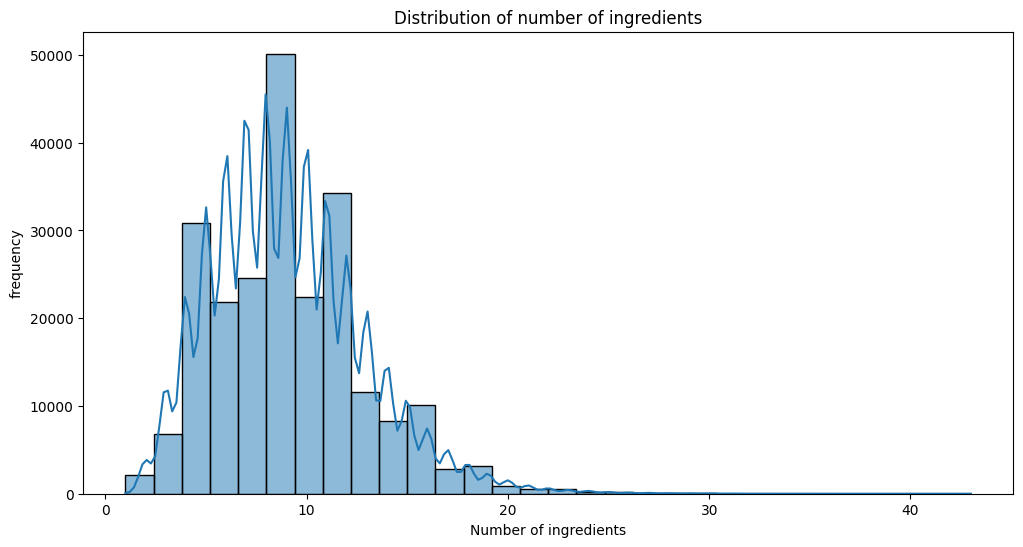

In [44]:
pplt.figure(figsize=(12, 6))
sbn.histplot(rec_data['n_ingredients'], bins=30, kde=True)
pplt.title('Distribution of number of ingredients')
pplt.xlabel('Number of ingredients')
pplt.ylabel('frequency')
pplt.show()

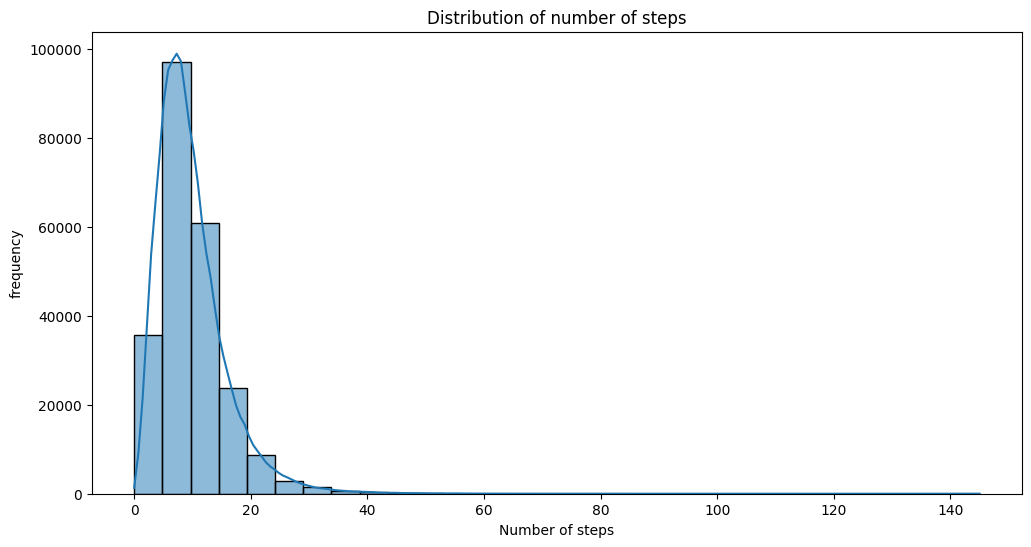

In [45]:
pplt.figure(figsize=(12, 6))
sbn.histplot(rec_data['n_steps'], bins=30, kde=True)
pplt.title('Distribution of number of steps')
pplt.xlabel('Number of steps')
pplt.ylabel('frequency')
pplt.show()

In [ ]:
total_tgs = rec_data['tags'].str.strip("[]").str.replace("'", "").str.split(", ")
total_tgs_f = sum(total_tgs.dropna(), []) # combining total tags into a single list

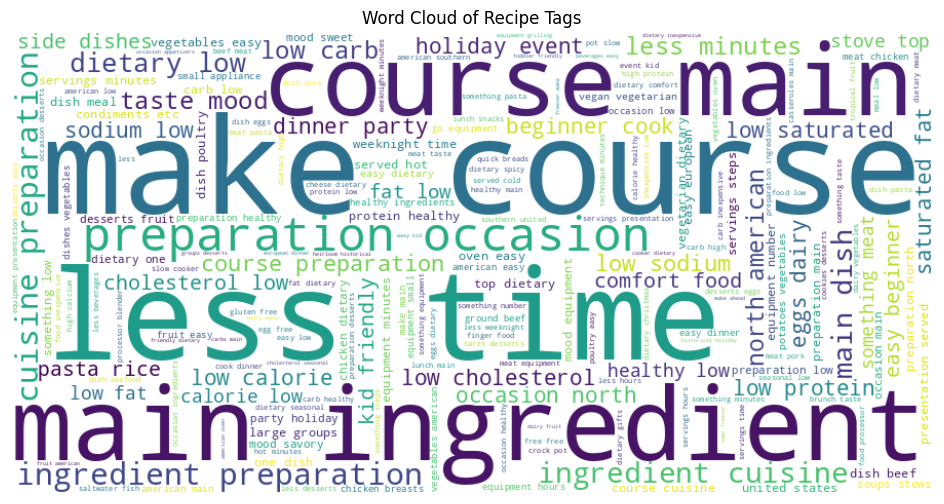

In [ ]:
pplt.figure(figsize=(12, 6))
wrdcld = WordCloud(width=900, height=450, background_color='white').generate(" ".join(total_tgs_f)) # generating word cloud for tags
pplt.imshow(wrdcld, interpolation='bilinear')
pplt.axis('off')
pplt.title("Word Cloud of Recipe Tags")
pplt.show()

*2*

In [8]:
stpwrds = set(stopwords.words('english'))

def preprcss_txt(txt):
    txt = txt.lower()
    cln_txt = ""
    for char in txt:
        if char.isalnum() or char == " ":
            cln_txt += char
        else:
            cln_txt += " "
    tkns = cln_txt.split()
    fltrd_tkns = []

    for wrd in tkns:
        if wrd not in stpwrds:
            fltrd_tkns.append(wrd)

    return fltrd_tkns

interact_data['processed_review'] = interact_data['review'].dropna().apply(preprcss_txt) # applying preprocessing to the 'review' column
#interact_data[['review', 'processed_review']].head()

*3*

In [9]:
def calc_rvw_len(txt):
    if isinstance(txt, str):
        return len(txt), len(txt.split())
    return (0, 0)

interact_data[['char_len', 'word_len']] = interact_data['review'].dropna().apply(calc_rvw_len).apply(panda.Series)

char_len_stats = interact_data['char_len'].describe().to_dict()
print("Character length statistics:")
for st, val in char_len_stats.items():
    print(f"{st}: {val}")
print()
wrd_len_stats = interact_data['word_len'].describe().to_dict()
print("Word length statistics:")
for st, val in wrd_len_stats.items():
    print(f"{st}: {val}")

Character length statistics:
count: 1132198.0
mean: 278.40948138046525
std: 197.3971521862078
min: 1.0
25%: 147.0
50%: 237.0
75%: 358.0
max: 8587.0

Word length statistics:
count: 1132198.0
mean: 52.02222932737914
std: 37.1400826822464
min: 0.0
25%: 27.0
50%: 44.0
75%: 67.0
max: 1182.0


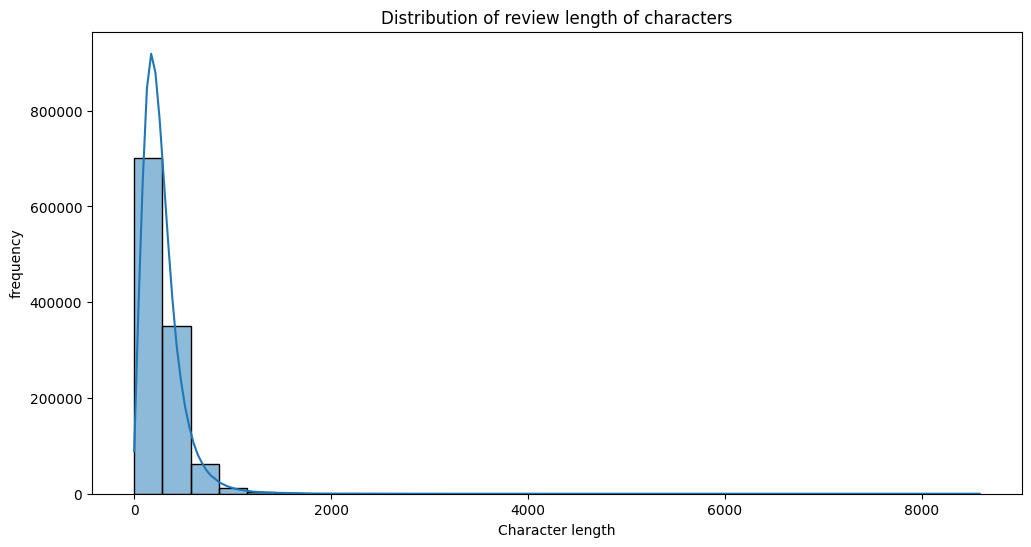

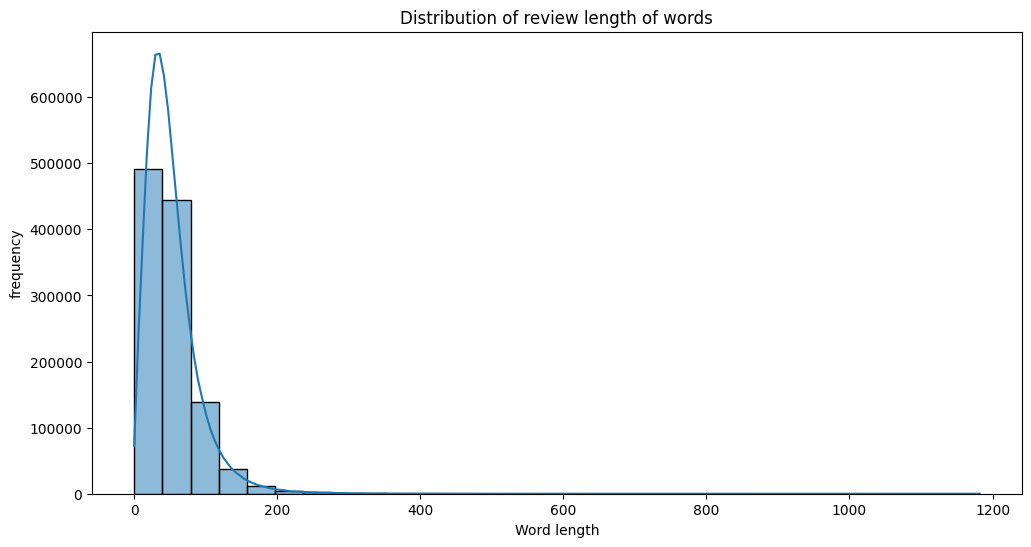

In [47]:
pplt.figure(figsize=(12, 6)) # visualizing distribution of review lengths of characters and words
sbn.histplot(interact_data['char_len'].dropna(), bins=30, kde=True)
pplt.title("Distribution of review length of characters")
pplt.xlabel("Character length")
pplt.ylabel("frequency")
pplt.show()

pplt.figure(figsize=(12, 6))
sbn.histplot(interact_data['word_len'].dropna(), bins=30, kde=True)
pplt.title("Distribution of review length of words")
pplt.xlabel("Word length")
pplt.ylabel("frequency")
pplt.show()

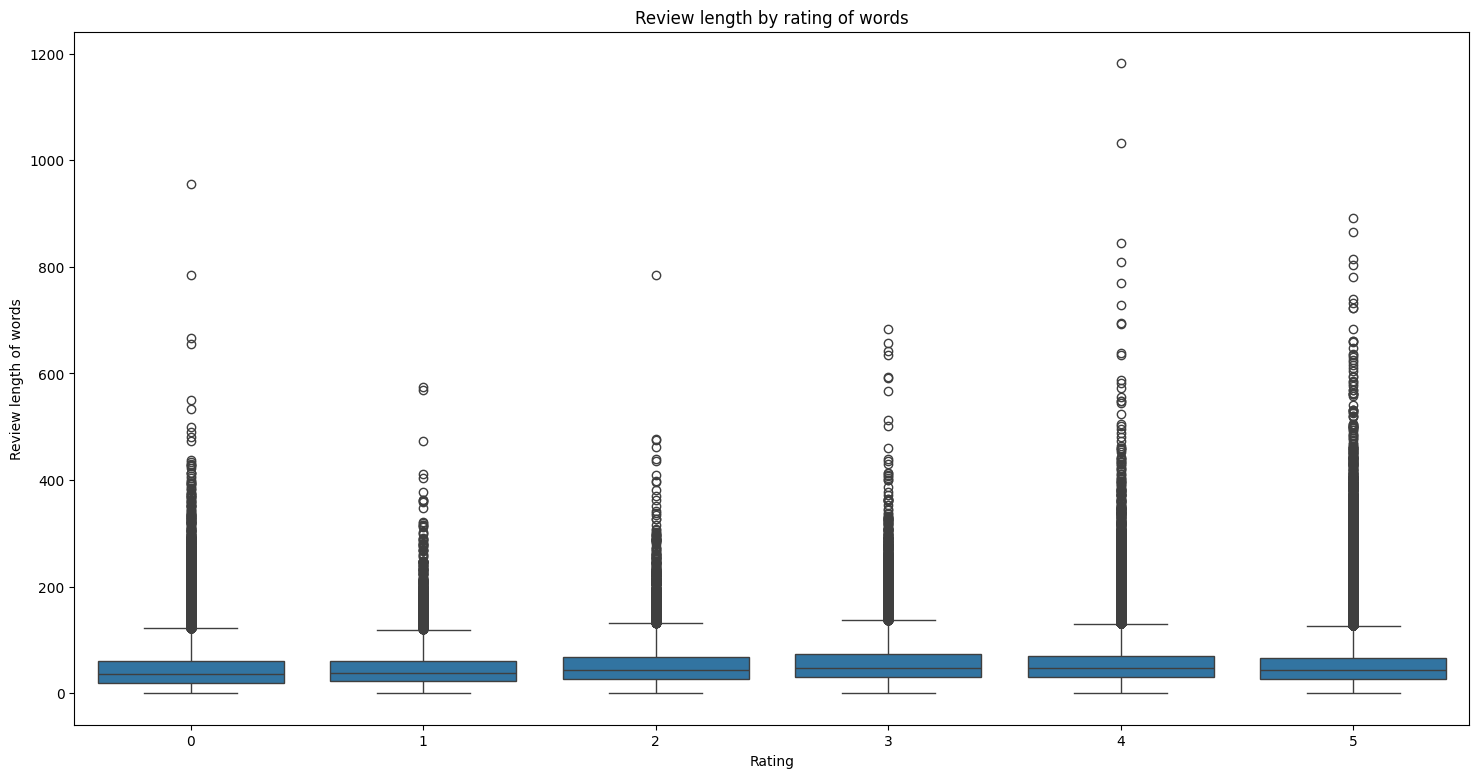

In [48]:
pplt.figure(figsize=(18, 9)) # comparing review lengths across different rating groups
sbn.boxplot(data=interact_data, x='rating', y='word_len')
pplt.title("Review length by rating of words")
pplt.xlabel("Rating")
pplt.ylabel("Review length of words")
pplt.show()

In [17]:
corr_rtng_wrd_len = interact_data['rating'].corr(interact_data['word_len'])
print(f"Correlation among rating and review's length (words): {corr_rtng_wrd_len}")

Correlation among rating and review's length (words): 0.01569089926422269


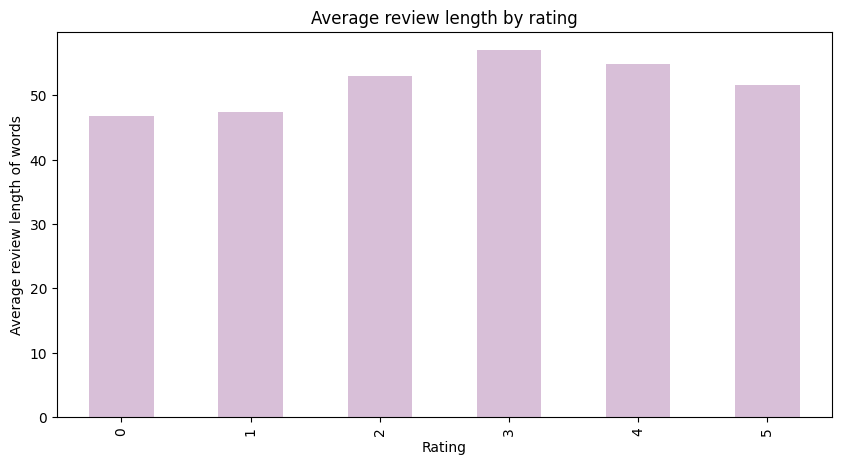

In [49]:
avg_wrd_len_rtng = interact_data.groupby('rating')['word_len'].mean() # plotting average review length for different rating groups
pplt.figure(figsize=(10, 5))
avg_wrd_len_rtng.plot(kind='bar', color='thistle')
pplt.title("Average review length by rating")
pplt.xlabel("Rating")
pplt.ylabel("Average review length of words")
pplt.show()

*4*

In [24]:
sid = SentimentIntensityAnalyzer() # initializing vader sentiment analyzer

def sent_rtng(txt): # for calculating sentiment score from 0-5
    if isinstance(txt, str):
        sent_sc = sid.polarity_scores(txt)['compound']  # polarity score from -1 to 1
        scld_sc = (sent_sc + 1) * 2.5  # maps -1 to 1 range into 0-5 range
        return round(scld_sc, 1)  # returning scaled score as rounded for consistency
    return 0

interact_data['sentiment_rating'] = interact_data['review'].apply(sent_rtng)

corr_sent = interact_data['rating'].corr(interact_data['sentiment_rating']) # calculating overall correlation between sentiment-based ratings and actual user ratings
print(f"Overall Correlation between Sentiment Score and User Rating: {corr_sent}")

Overall Correlation between Sentiment Score and User Rating: 0.33885791043761515


In [26]:
for r in sorted(interact_data['rating'].unique()):
    grp_data = interact_data[interact_data['rating'] == r]
    sent_stats = grp_data['sentiment_rating'].describe().to_dict()
    print(f"Sentiment scores for rating {r}:")
    for st, val in sent_stats.items():
        print(f"{st}: {val}")
    print()

Sentiment scores for rating 0:
count: 60847.0
mean: 3.865087843279044
std: 1.1366261668850202
min: 0.0
25%: 3.3
50%: 4.3
75%: 4.7
max: 5.0

Sentiment scores for rating 1:
count: 12818.0
mean: 2.4361366827898263
std: 1.3977590343877986
min: 0.0
25%: 1.2
50%: 2.5
75%: 3.6
max: 5.0

Sentiment scores for rating 2:
count: 14123.0
mean: 3.106294696594208
std: 1.3295048822554374
min: 0.0
25%: 2.1
50%: 3.3
75%: 4.3
max: 5.0

Sentiment scores for rating 3:
count: 40855.0
mean: 3.7826092277567005
std: 1.1381030916785093
min: 0.0
25%: 3.1
50%: 4.2
75%: 4.7
max: 5.0

Sentiment scores for rating 4:
count: 187360.0
mean: 4.361704739538857
std: 0.7370780313411611
min: 0.0
25%: 4.2
50%: 4.6
75%: 4.8
max: 5.0

Sentiment scores for rating 5:
count: 816364.0
mean: 4.541629836690497
std: 0.5947362023238424
min: 0.0
25%: 4.5
50%: 4.8
75%: 4.9
max: 5.0



*7*

In [43]:
csns = ['Italian', 'Mexican', 'Chinese', 'Indian', 'French', 'Thai', 'Japanese']
main_ings = ['chicken', 'beef', 'lamb', 'pasta', 'rice', 'potato', 'cheese', 'butter', 'fish']

def csn_finding(tags): # functions for extracting cuisine and ingredient from tags
    tgs_lst = tags.lower().strip("[]").replace("'", "").split(", ")
    for c in csns:
        if c.lower() in tgs_lst:
            return c
    return 'Other'

def identify_ings(tags):
    tgs_lst = tags.lower().strip("[]").replace("'", "").split(", ")
    for m in main_ings:
        if m.lower() in tgs_lst:
            return m
    return 'Other'

rec_data['cuisine'] = rec_data['tags'].fillna('').apply(csn_finding)
rec_data['main_ingredient'] = rec_data['tags'].fillna('').apply(identify_ings)

# merging cuisine and main ingredient info with interact_data based on recipe_id
interact_data = interact_data.merge(rec_data[['recipe_id', 'cuisine', 'main_ingredient']], left_on='recipe_id', right_on='recipe_id', how='left', suffixes=('', '_rec'))
interact_data = interact_data.rename(columns={'cuisine': 'cuisine_interact', 'main_ingredient': 'main_ingredient_interact'})
interact_data = interact_data.rename(columns={'cuisine_rec': 'cuisine', 'main_ingredient_rec': 'main_ingredient'})

csn_sent = interact_data.groupby('cuisine')['sentiment_rating'].mean().sort_values()
ing_sent = interact_data.groupby('main_ingredient')['sentiment_rating'].mean().sort_values()

print("Average Sentiment by Cuisine:")
print(csn_sent.to_string().replace('cuisine', ''))
print()
print("Average Sentiment by Main Ingredient:")
print(ing_sent.to_string().replace('main_ingredient',''))

Average Sentiment by Cuisine:

Japanese    4.367674
Chinese     4.371495
Indian      4.392213
Thai        4.394937
Other       4.404956
Mexican     4.420735
Italian     4.431880
French      4.462783

Average Sentiment by Main Ingredient:

beef       4.385534
Other      4.403710
rice       4.407528
chicken    4.416792
pasta      4.419438
cheese     4.429838
fish       4.431768


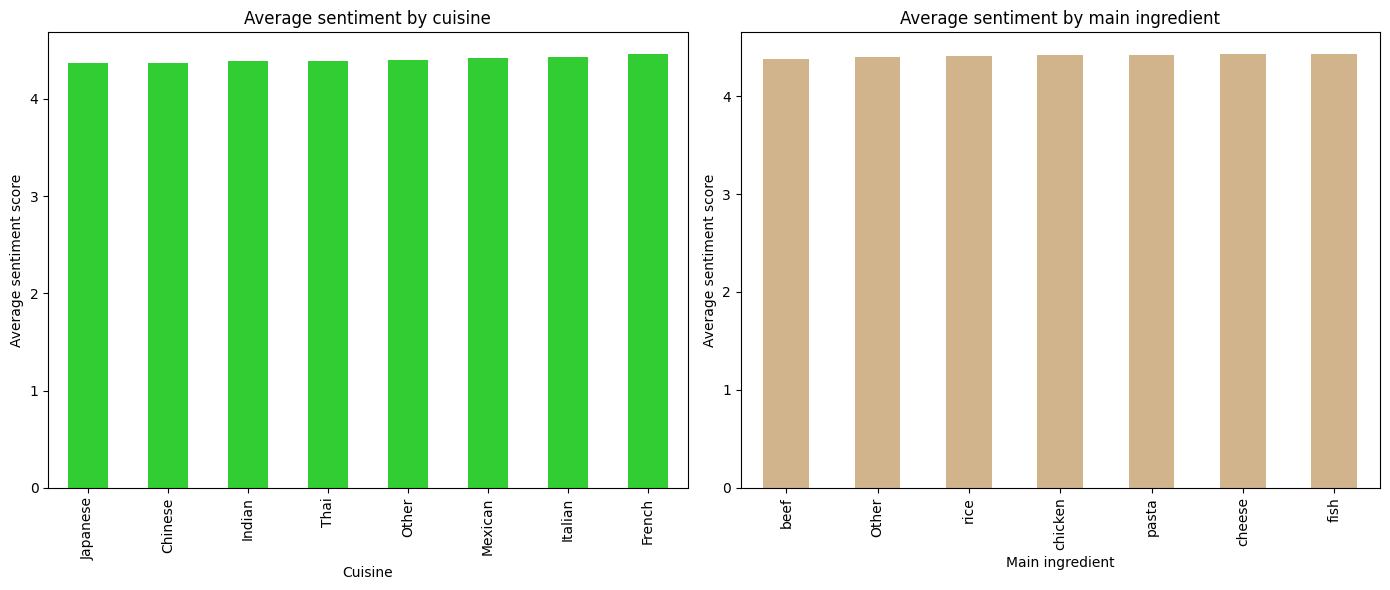

In [50]:
pplt.figure(figsize=(14, 6))

pplt.subplot(1, 2, 1) # plotting cuisine sentiment Scores
csn_sent.plot(kind='bar', color='limegreen')
pplt.title("Average sentiment by cuisine")
pplt.xlabel("Cuisine")
pplt.ylabel("Average sentiment score")

pplt.subplot(1, 2, 2) # plotting ingredient sentiment scores
ing_sent.plot(kind='bar', color='tan')
pplt.title("Average sentiment by main ingredient")
pplt.xlabel("Main ingredient")
pplt.ylabel("Average sentiment score")

pplt.tight_layout()
pplt.show()

The data shows that for cuisines and ingredients that received high scores such as French and Italian cuisine, as well as rice and chicken, I may be able to predict users' preferences to recommend recipes. It is possible that increasing the range of missing cuisines and ingredients can even increase the level of satisfaction and interest from users.